# Neural Networks

Train neural network classifier to distinguish normal from abnormal gait using wireless sensor data.

In [1]:
import itertools

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np

In [4]:
import os

In [5]:
import pandas as pd

In [6]:
import pickle

In [7]:
import psutil

In [8]:
import time

In [9]:
from imblearn.under_sampling import RandomUnderSampler

In [10]:
from pympler import asizeof

In [11]:
from sklearn.metrics import auc, confusion_matrix, f1_score, roc_curve

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
from sklearn.neural_network import MLPClassifier

***

## Load Data

In [14]:
datafile = os.path.join('..', 'data', 'processed', 'combined_cond_ranges.csv')
data = pd.read_csv(datafile)
X = data.iloc[:, 1:7].values
y = data.iloc[:, 7].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**2018 May 13**

First step is to attempt training a simple artificial neural network with a single hidden layer and evaluate its performance. 

Using TensorFlow's high-level API, set the number of units in the hidden layer, train using the full training dataset, and evaluate on the held-out test set. No hyperparameter tuning is done.

The code below gives an test set accuracy of 0.890625, but eats up all the GPU memory:

**2018 May 14**

Using TensorFlow without the high-level API (i.e. using `tf.layers.dense`) throw errors or give NaNs. Due to these current difficulties Scikit-Learn's neural network API will be used below.

## Class Imbalance

**2018 May 14, 16; July 28**

The dataset has class imbalance, with significantly fewer positives (abnormal gait) than negatives (normal gait). To correct for this, downsample the majority class.

In [15]:
rus = RandomUnderSampler(random_state=0)
X_resamp, y_resamp = rus.fit_sample(X_train, y_train)

For hyperparameter tuning, further split the training data into a training and validation set:

In [122]:
(X_resamp_train, X_resamp_valid, 
 y_resamp_train, y_resamp_valid) = train_test_split(X_resamp, y_resamp, test_size=0.2)

The hyperparameters to evaluate are number of layers and number of neurons in each layer:

In [17]:
layer_params = [(3,), (4,), (5,), (6,), (7,), (8,), 
                (3,2), (4,2), (4,3), (5,2), (5,3), (5,4)]

In [179]:
start_time = time.perf_counter()

for layer_config in layer_params:
    clf = MLPClassifier(hidden_layer_sizes=layer_config, activation='logistic', 
                        learning_rate_init=0.01, max_iter=10000, random_state=157)
    clf.fit(X_resamp_train, y_resamp_train)
    y_valid_pred = clf.predict(X_resamp_valid)
    y_valid_prob = clf.predict_proba(X_resamp_valid)
    valid_fpr, valid_tpr, _ = roc_curve(y_resamp_valid, y_valid_prob[:, 1])
    print('Layer config:', layer_config, 
          '\tAccuracy: {:.3f}'.format(clf.score(X_resamp_valid, y_resamp_valid)), 
          '\tF1: {:.3f}'.format(f1_score(y_resamp_valid, y_valid_pred)), 
          '\tAUC: {:.3f}'.format(auc(valid_fpr, valid_tpr)))

elapsed_time = time.perf_counter() - start_time
print('\nElasped time: ', elapsed_time)

Layer config: (3,) 	Accuracy: 0.895 	F1: 0.800 	AUC: 0.986
Layer config: (4,) 	Accuracy: 0.895 	F1: 0.800 	AUC: 0.986
Layer config: (5,) 	Accuracy: 0.947 	F1: 0.909 	AUC: 1.000
Layer config: (6,) 	Accuracy: 0.895 	F1: 0.800 	AUC: 0.986
Layer config: (7,) 	Accuracy: 0.947 	F1: 0.909 	AUC: 0.986
Layer config: (8,) 	Accuracy: 0.947 	F1: 0.909 	AUC: 0.986
Layer config: (3, 2) 	Accuracy: 0.263 	F1: 0.417 	AUC: 0.757
Layer config: (4, 2) 	Accuracy: 0.263 	F1: 0.417 	AUC: 0.857
Layer config: (4, 3) 	Accuracy: 0.895 	F1: 0.800 	AUC: 0.986
Layer config: (5, 2) 	Accuracy: 0.947 	F1: 0.909 	AUC: 0.943
Layer config: (5, 3) 	Accuracy: 0.263 	F1: 0.417 	AUC: 0.786
Layer config: (5, 4) 	Accuracy: 0.263 	F1: 0.417 	AUC: 0.757

Elasped time:  2.640490054996917


Save model

In [183]:
with open(os.path.join('..', 'results', 'nn_3foldCV.pkl'), 'wb') as f:
    pickle.dump(clf, f)

Profiling memory usage by determining how much memory Python is using

In [182]:
process = psutil.Process(os.getpid())
print(process.memory_info().rss)

79212544


Using the best layer config as determined by the validation set, fit model on full (resampled) training set and compute performance on test set:

In [16]:
final_clf = MLPClassifier(hidden_layer_sizes=(5,), activation='logistic', 
                          learning_rate_init=0.01, max_iter=10000, random_state=12)
final_clf.fit(X_resamp, y_resamp)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5,), learning_rate='constant',
       learning_rate_init=0.01, max_iter=10000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=12, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

Save trained classifier

In [22]:
with open(os.path.join('..', 'results', 'nn_trained.pkl'), 'wb') as f:
    pickle.dump(final_clf, f)

In [17]:
final_clf.score(X_test, y_test)

0.9375

The memory usage of the trained `MLPClassifier` itself:

In [187]:
asizeof.asizeof(final_clf)

56336

Make predictions and measure execution time:

In [188]:
%timeit final_clf.predict(X_test)

64.7 µs ± 305 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [18]:
y_pred = final_clf.predict(X_test)

In [19]:
cnf_matrix = confusion_matrix(y_test, y_pred)

In [20]:
cnf_matrix

array([[48,  4],
       [ 0, 12]])

In [21]:
spec, sens = cnf_matrix.diagonal() / np.sum(cnf_matrix, axis=1)
print(f'Sensitivity = {sens}\nSpecificity = {spec}')

Sensitivity = 1.0
Specificity = 0.9230769230769231


Plot confusion matrix (code copied from scikit-learn [Confusion matrix](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)):

In [26]:
def plot_confusion_matrix(cm, classes, normalize=False, 
                          title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    Print and plot confusion matrix. Normalization can be applied by setting 
    `normalize=True`
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize='xx-large')
    tick_marks = np.arange(len(classes))
    ax = plt.gca()
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, fontsize='large')
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes, rotation=90, va='center', minor=False, 
                       fontsize='large')
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                 horizontalalignment='center', fontsize=20, 
                 color='white' if cm[i, j] > thresh else 'black')
    plt.xlabel('Predicted label', fontsize='x-large')
    plt.ylabel('True label', fontsize='x-large')

In [27]:
class_names = ['Normal', 'Abnormal']

<Figure size 640x480 with 0 Axes>

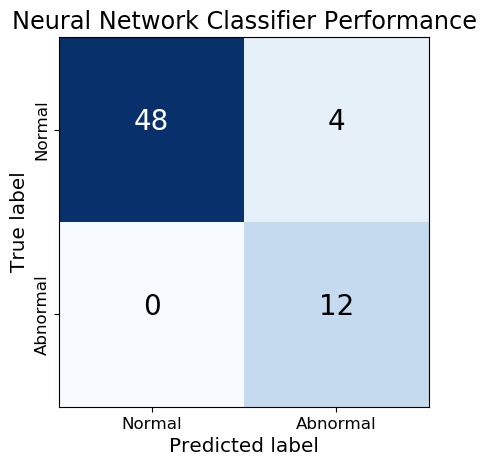

In [29]:
plot_title = 'Neural Network Classifier Performance'
plt.clf()
plt.style.use('default')
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title=plot_title)
cnf_filename = os.path.join('..', 'results', 'nn_cnf_matrix.svg')
plt.savefig(cnf_filename)
plt.show()

Plot ROC curve:

In [30]:
y_score = final_clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

<Figure size 640x480 with 0 Axes>

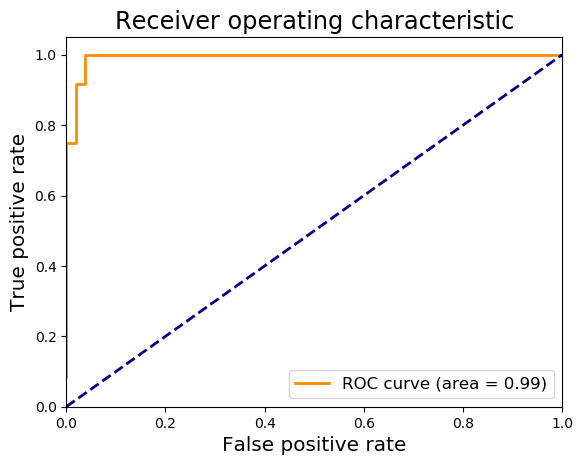

In [32]:
plt.clf()
plt.style.use('default')
plt.figure()
lw_ = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw_, 
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw_, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate', fontsize='x-large')
plt.ylabel('True positive rate', fontsize='x-large')
plt.title('Receiver operating characteristic', fontsize='xx-large')
plt.legend(loc='lower right', fontsize='large')
roc_filename = os.path.join('..', 'results', 'nn_roc.svg')
plt.savefig(roc_filename)
plt.show()